# Conflict Forecast ADM2 MAPS

This code produces maps based on a adm2 shape file and the latest download from the adm2 violence forecast dataset that is updated on a monthly basis at https://conflictforecast.org/. To access the code book go to our download section at https://conflictforecast.org/downloads.


If you use this code or data please cite as:
1) Mueller, Hannes, Christopher Rauh (2022) The Hard Problem of Prediction for Conflict Prevention, Journal of the European Economic Association, volumne 20(6), pp. 2440–2467, https://doi.org/10.1093/jeea/jvac025.

2) Mueller, Hannes, Christopher Rauh, and Ben Seimon (2024) Introducing a global dataset on conflict forecasts and news topics. Data & Policy, volume 6, https://doi.org/10.1017/dap.2024.10.

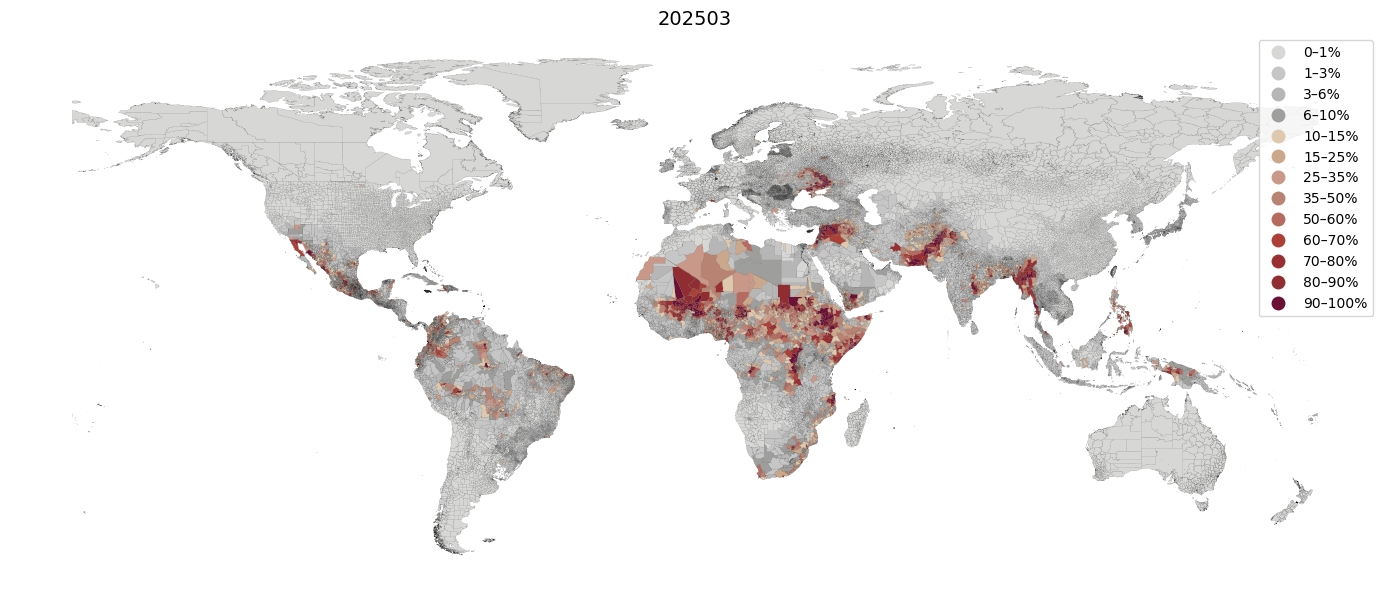

In [45]:
#!/usr/bin/env python3
# draw_conflict_map.py  – 11-bin percentile version
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# ------------------------------------------------------------------
# 1)  load data
# ------------------------------------------------------------------
shp_path = Path(path+"adm2.shp")
csv_path = Path(path+"latest_adm2_any_violence_12.csv")

gdf = gpd.read_file(shp_path)
df  = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2)  keep only the latest period
# ------------------------------------------------------------------
latest_period = df["period"].max()              # adjust if period isn't sortable
df_latest     = df.loc[df["period"] == latest_period].copy()

# ------------------------------------------------------------------
# 3)  merge on the shape identifier
# ------------------------------------------------------------------
shp_id_col = "shapeID"
csv_id_col = "shapeID"

merged = gdf.merge(
    df_latest[[csv_id_col, "preds"]],
    left_on  = shp_id_col,
    right_on = csv_id_col,
    how      = "left"
)


value_bins = [0.00, 0.01, 0.03, 0.06, 0.10, 0.15, 0.25,
              0.35, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]    # 13 edges → 12 bins
n_bins     = len(value_bins) - 1

labels     = [f"{int(value_bins[i]*100)}–{int(value_bins[i+1]*100)}%"
              for i in range(n_bins)]


merged["pred_bin"] = pd.cut(
    merged["preds"],
    bins           = value_bins,
    labels         = labels,
    include_lowest = True,
    ordered        = True
)

# ------------------------------------------------------------------
# 3)  colour map  (12 discrete tones, greys first)
# ------------------------------------------------------------------
anchor = [
    "#d7d7d6", "#c6c6c6", "#b6b6b6", "#9d9d9d",
    "#dfc9ae", "#cba88c", "#ca9988", "#b98373",
    "#b76a60", "#ad4137", "#992f32", "#902d32", "#6a1135"
]
gradient = LinearSegmentedColormap.from_list("grey_pink_orange_red", anchor, N=256)
cmap     = ListedColormap(gradient(np.linspace(0, 1, n_bins)))

# ------------------------------------------------------------------
# 6)  plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))
merged.plot(
    column     ="pred_bin",
    cmap       = cmap,
    linewidth  = 0.05,
    edgecolor  = "black",
    legend     = True,
    ax         = ax,
    categorical= True
)

# title = just year-month
period_dt = pd.to_datetime(str(latest_period), errors="coerce")
ax.set_title(period_dt.strftime("%B %Y") if period_dt is not pd.NaT else str(latest_period),
             fontsize=14)

ax.set_axis_off()
plt.tight_layout()
plt.savefig("latest_conflict_map.png", dpi=300)
plt.show()




In [43]:
# ------------------------------------------------------------------
# 7)  print distribution table to the console
# ------------------------------------------------------------------
dist = merged["pred_bin"].value_counts().sort_index()
print("\nDistribution of ADM-2 units by risk bin:\n")
print(dist.to_string())
print("\n✓ Map saved as   latest_conflict_map.png")


Distribution of ADM-2 units by risk bin:

pred_bin
0–1%       30749
1–3%        7750
3–6%        2714
6–10%       2323
10–15%      1266
15–25%      1424
25–35%       705
35–50%       682
50–60%       372
60–70%       300
70–80%       228
80–90%       218
90–100%      243

✓ Map saved as   latest_conflict_map.png


In [47]:
#!/usr/bin/env python3
# draw_conflict_maps_to_gif.py
#
# Requirements:
#   pip install geopandas pandas matplotlib numpy imageio tqdm
# ------------------------------------------------------------------
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
from pathlib import Path
from tqdm import tqdm                        # progress bar

# ------------------------------------------------------------------
# 0)  user settings -------------------------------------------------
# ------------------------------------------------------------------
path="/Users/hannesfelixmuller/Dropbox/War&Peace/subnational_movie/"           # <— adjust
shp_path   = Path(path) / "adm2.shp"
csv_path   = Path(path) / "latest_adm2_any_violence_12.csv"

out_dir    = Path("maps")                    # folder that will hold PNGs
out_dir.mkdir(exist_ok=True)

gif_path   = Path("conflict_maps_202001-202503.gif")
fps        = 1.25                            # frames per second in the GIF

# ------------------------------------------------------------------
# 1)  load data -----------------------------------------------------
# ------------------------------------------------------------------
gdf = gpd.read_file(shp_path)
df  = pd.read_csv(csv_path)

# make sure “period” is a zero-padded string such as "202001"
df["period"] = df["period"].astype(str).str.zfill(6)

# ------------------------------------------------------------------
# 2)  generate the list of periods 202001 … 202503 ------------------
# ------------------------------------------------------------------
periods = (
    pd.period_range(start="2020-01", end="2025-03", freq="M")
      .strftime("%Y%m")
      .tolist()
)

# ------------------------------------------------------------------
# 3)  colour bins and colour map (identical for every frame) -------
# ------------------------------------------------------------------
value_bins = [0.00, 0.01, 0.03, 0.06, 0.10, 0.15, 0.25,
              0.35, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]    # 13 edges → 12 bins
n_bins     = len(value_bins) - 1

labels     = [f"{int(value_bins[i]*100)}–{int(value_bins[i+1]*100)}%"
              for i in range(n_bins)]

anchor = [
    "#d7d7d6", "#c6c6c6", "#b6b6b6", "#9d9d9d",
    "#dfc9ae", "#cba88c", "#ca9988", "#b98373",
    "#b76a60", "#ad4137", "#992f32", "#902d32", "#6a1135"
]
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
gradient = LinearSegmentedColormap.from_list("grey_pink_orange_red", anchor, N=256)
cmap     = ListedColormap(gradient(np.linspace(0, 1, n_bins)))

# ------------------------------------------------------------------
# 4)  loop over every period ---------------------------------------
# ------------------------------------------------------------------
for period in tqdm(periods, desc="Drawing maps"):

    df_period = df.loc[df["period"] == period].copy()
    if df_period.empty:                      # skip missing periods
        continue

    merged = gdf.merge(
        df_period[["shapeID", "preds"]],
        left_on  = "shapeID",
        right_on = "shapeID",
        how      = "left",
    )

    merged["pred_bin"] = pd.cut(
        merged["preds"],
        bins           = value_bins,
        labels         = labels,
        include_lowest = True,
        ordered        = True,
    )

    # ---------- plot ------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

    merged.plot(
        column      = "pred_bin",
        cmap        = cmap,
        linewidth   = 0.05,
        edgecolor   = "black",
        legend      = True,
        ax          = ax,
        categorical = True,
    )

    # convert “202001” → “January 2020”
    period_dt = pd.to_datetime(period, format="%Y%m")
    ax.set_title(period_dt.strftime("%B %Y"), fontsize=16, weight="bold")

    ax.set_axis_off()
    plt.tight_layout()

    outfile = out_dir / f"map_{period}.png"
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.close(fig)

# ------------------------------------------------------------------
# 5)  assemble GIF --------------------------------------------------
# ------------------------------------------------------------------
frames = []
for png in sorted(out_dir.glob("map_*.png")):    # sorted chronologically
    frames.append(imageio.imread(png))

imageio.mimsave(gif_path, frames, fps=fps)
print(f"Saved animated map GIF → {gif_path.resolve()}")


Drawing maps: 100%|█████████████████████████████| 63/63 [12:05<00:00, 11.51s/it]


Saved animated map GIF → /Users/hannesfelixmuller/Dropbox/War&Peace/subnational_movie/code/conflict_maps_202001-202503.gif
